<a href="https://colab.research.google.com/github/Migaalee/machine_learning/blob/main/Assignment1_AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Project description
## Dataset 
The data set is inspired on the banknote authentication problem in the UCI machine learning repository, but the data was adapted for this assignment. The data are available on .tsv files where each line corresponds to a bank note and the five values, separated by commas, are, in order, the four features (variance, skewness and curtosis of Wavelet Transformed image and the entropy of the bank note image) and the class label, an integer with values 0 for real bank notes and 1 for fake bank notes.

## Objective
Parametrize, fit and compare Naive Bayes and Support Vector Machine classifiers using described dataset.

# Import all packages that will be used

In [1]:
import numpy as np # Numpy for data management
import pandas as pd # Pandas also for data management
from matplotlib import pyplot as plt # Matplotlib for additional customization
%matplotlib inline
import math

#ScikitLearn:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

from google.colab import files #this is to load files from your local disk

# Upload data

Import training dataset

In [2]:
TP1_train = files.upload() 
 

Saving TP1_train.tsv to TP1_train.tsv


Import testing dataset

In [3]:
TP1_test = files.upload()

Saving TP1_test.tsv to TP1_test.tsv


# Data preparation

Read data, shuffle, standardize

In [4]:
# Read data
mat_train = np.loadtxt("TP1_train.tsv", delimiter="\t")
mat_test = np.loadtxt("TP1_test.tsv", delimiter="\t")

# Shuffle data
data_train = shuffle(mat_train)
data_test = shuffle(mat_test)

# Standardize training dataset
Y_r = data_train[:,4] #classes
X_r = data_train[:,:4] #features
means_r = np.mean(X_r, axis = 0)
stdvs_r = np.std(X_r,axis = 0)
X_r = (X_r-means_r)/stdvs_r

# Standardize testing dataset
Y_t = data_test[:,4]
X_t = data_test[:,:4]
means_t = np.mean(X_t, axis = 0)
stdvs_t = np.std(X_t,axis = 0)
X_t = (X_t-means_t)/stdvs_t

 Naive Bayes



# Bayes classifiers

You must implement your own Naïve Bayes classifier using Kernel Density Estimation for the probability distributions of the feature values. For this, you can use any code from the lectures, lecture notes and tutorials that you find useful. Also, use the KernelDensity class from sklearn.neighbors.kde for the density estimation.

Use the same bandwidth value for all the Kernel Density Estimators in each instance of your Naïve Bayes classifier, and try values from 0.02 to 0.6 with a step of 0.02 for the bandwidth.
Use the default kernel ('gaussian') for the Kernel Density Estimators.

Funcao que calcula a prob de cada classe

In [5]:
def log_prob_classe(data): #calculating prior probability: data includes only the classes so we can calculate the probability of each class
    classe1 = 0
    for value in data: #value can be 0 or 1, for class 0 and 1
        value = int(value)
        if value == 1:
            classe1 += 1 #each time class 1 appear, we sum one so we can count the number of times it appears
    log_classe1 =  math.log( classe1 / len(data) ) #prob(class1) = number of C=1 dividing by the total number of examples; we use the logarithm
    log_classe0 = math.log( 1 - classe1 / len(data) ) #prob(class0) = 1 - prob(class1)
    return log_classe0, log_classe1 #the function returns the logarithm of the probability of each class

log_prob_r0, log_prob_r1 = log_prob_classe(Y_r)
log_prob_t0, log_prob_t1 = log_prob_classe(Y_t)

Funcao que separa os data sets por classe 

In [6]:
def sep_class(data_X, data_Y): 
    X0 = []
    X1 = []
 
    for i, value in enumerate(data_Y):
        value = int(value)
        if value == 0:
            X0 += [[data_X[i,0], data_X[i,1], data_X[i,2], data_X[i,3]]] 
        elif value == 1:
            X1 += [[data_X[i,0], data_X[i,1], data_X[i,2], data_X[i,3]]]
    return X0, X1

Xr_0, Xr_1 = sep_class(X_r, Y_r)
Xt_0, Xt_1 = sep_class(X_t, Y_t)

In [8]:
#print(X_r)
#print(Xr_0, Xr_1)

### Function for Naive Bayes (good one)

In [10]:
def fit_NBayes(X, Y, feat_matrix, bw):
    
    classes = np.zeros(feat_matrix.shape[0]) #make a matrix with zeros with shape of our dataset rows . uma lista com 1247 listas de 4 elementos

    X_0, X_1 = sep_class(X, Y)
    prob_class0 = []
    prob_class1 = [] 

    # probabilities in ln to be able to sum later with score_samples, which are also in ln. Easier then multiplying probabilities without log  
    log_prob_r0, log_prob_r1 = log_prob_classe(Y_r) #aqui chamamos a funcao que da o log da probabilidade de classe

    for feature in range(len(X_r[0])):        #for feature 1 to 4
        column = []
        for elem in X_0:
          column += [[elem[feature]]]
        kde0 = KernelDensity(bandwidth=bw)
        kde0.fit(column)
        prob_class0 += [kde0.score_samples(feat_matrix[:, [feature]])]
       
    for feature in range(len(X_1[0])):  
        column = []
        for elem in X_1:
          column += [[elem[feature]]]      
        kde1 = KernelDensity(bandwidth=bw)
        kde1.fit(column)
        prob_class1 += [kde1.score_samples(feat_matrix[:, [feature]])]


    class0_sum = []
    class1_sum = []
    for i in range(len(prob_class0[0])) :
      sum0 = log_prob_r0
      sum1 = log_prob_r1
      for j in range(len(prob_class0)) :
        sum0 += prob_class0[j][i]
        sum1 += prob_class1[j][i]
      class0_sum += [sum0]  
      class1_sum += [sum1]
  
    for ix in range(0, np.shape(classes)[0]): #we compute a matrix of 0: default class = 0
      if class0_sum[ix] < class1_sum[ix]: #if the prob(class1) maximizes the prob
        classes[ix] = 1 #we change it to class 1

    return classes


#a = fit_NBayes(X_r, Y_r, X_t,  0.02)
#print(a)

Função para definir a melhor bandwidth

In [11]:
bandwidth_range = np.arange(0.02,0.61,0.02) # To optimize the bandwidth of the kernel try values from 0.02 to 0.6 with a step of 0.02

train_err=[]
valid_err=[]
folds = 5
kf = StratifiedKFold(n_splits=folds)

for bw in bandwidth_range:
  tr_err = va_err = 0

  for tr_ix,va_ix in kf.split(Y_r,Y_r):
    x_t = X_r[tr_ix]
    y_t = Y_r[tr_ix]
    x_v = X_r[va_ix]
    y_v = Y_r[va_ix]

    c_t = fit_NBayes(x_t, y_t, x_t, bw)  ##X, Y, bw, feat_matrix
    c_v = fit_NBayes(x_t, y_t, x_v, bw)

    nb_t_error = 1-metrics.accuracy_score(y_t, c_t) #calculate error with training set for that fold
    tr_err += nb_t_error
    nb_v_error = 1-metrics.accuracy_score(y_v, c_v) #calculate validation error for that fold with a validation dataset
    va_err += nb_v_error

  train_err.append(tr_err/folds)
  valid_err.append(va_err/folds)
  print(str(np.round(bw,2)),':', tr_err/folds,va_err/folds)

0.02 : 0.03892480654815855 0.07062811244979919
0.04 : 0.050361324938671424 0.06581847389558235
0.06 : 0.055377779926123735 0.06662168674698794
0.08 : 0.05517737952814265 0.06501847389558232
0.1 : 0.056180589962659046 0.06341204819277109
0.12 : 0.05758480260057282 0.06421204819277108
0.14 : 0.05838741122967297 0.06340883534136546
0.16 : 0.05858821444252436 0.06421204819277108
0.18 : 0.05919022126620828 0.0650152610441767
0.2 : 0.06079523711697341 0.06421204819277108
0.22 : 0.06079523711697341 0.0634120481927711
0.24 : 0.06119664213524108 0.0634120481927711
0.26 : 0.060795438524408586 0.06421526104417671
0.28 : 0.06179864895892499 0.06421526104417671
0.3 : 0.061798447551489846 0.06421526104417671
0.32 : 0.06199884794947093 0.0634120481927711
0.34 : 0.06280145657857109 0.06421526104417671
0.36 : 0.06320266018940354 0.06341526104417672
0.38 : 0.06360386380023604 0.06341526104417672
0.4 : 0.06400506741106855 0.06421847389558236
0.42 : 0.06420607203135509 0.06341526104417672
0.44 : 0.0646076

Plot do gráfico para comparar o erro de teste e treino para diferentes bandwidh

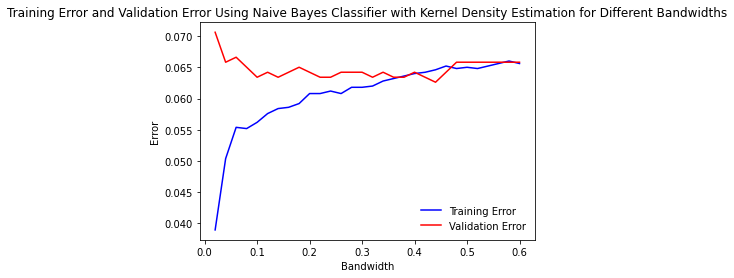

In [12]:
#PLOT THE ERROR OF THE TRAIN AND TEST SET  
plt.plot(bandwidth_range, train_err,'b',label = 'Training Error') 
plt.plot(bandwidth_range,valid_err,'r',label = 'Validation Error')
plt.title('Training Error and Validation Error Using Naive Bayes Classifier with Kernel Density Estimation for Different Bandwidths') 
plt.xlabel('Bandwidth')
plt.ylabel('Error')
plt.legend(loc='lower right',frameon=False)
plt.show()
plt.close()

Show best bandwidth

In [13]:
best_bw = bandwidth_range[np.argmin(valid_err)]
print("smallest validation error is: "+ str(np.min(valid_err)))
print("best bandwith is: ", best_bw)

smallest validation error is: 0.06261204819277108
best bandwith is:  0.44


Calculate True error with a test dataset

In [14]:
bayes_full_training = fit_NBayes(X_r, Y_r, X_t, bw=best_bw)  ##X, Y, feat_matrix, best_bw
bayes_true_error= 1-metrics.accuracy_score(Y_t, bayes_full_training)
print ('Bayes true error is: ', np.round(bayes_true_error,6))

Bayes true error is:  0.098637


## Gaussian Bayes

In [15]:
NB_gaussian = GaussianNB() #criar o modelo do Naive Bayes usando Gaussiana
NB_gaussian.fit(X_r, Y_r) #usar os nossos dados de treino para fazer fit ao modelo
NB_gaussian_score = NB_gaussian.score(X_r, Y_r) #TODO confirmar q isto está bem!!! #aqui temos o score de avaliacao deste modelo

NB_gaussian_probs = NB_gaussian.predict_proba(X_t) #aqui podemos ver as probabilidades de ser classe 0 ou classe 1, sendo que a classe prevista é a q aumenta esta probabilidade
NB_gaussian_predict = NB_gaussian.predict(X_t) #aqui temos as previsoes do nosso modelo para o X de teste, podemos comparar estes resultados com o Y_t 

# SVM classifier

Notes: use a Support Vector Machine with a Gaussian radial basis function, available in the sklearn.svm.SVC class. Use a regularization factor C = 1 and optimize the gamma parameter with cross-validation on the training set. The SVM classifier you will use has two adjustable parameters, gamma and C. In this assignment we fixed parameter C at a value of 1 but you can try to improve the performance of this classifier by adjusting simultaneously these two parameters. This is an optional exercise, worth only 1/20 of the assignment grade: optimize both parameters, compare the optimized SVM with the previous classifiers and discuss whether this additional optimization was useful in this case. Use 5 folds for cross validation

##### Make a function to caculate best gamma



In [16]:
from sklearn.svm import SVC

gamma_range = np.arange(0.2,6.2,0.2) # To optimize the gamma parameter of the SVM try values from 0.2 to 6 with a step of 0.2

train_err=[]
valid_err=[]
folds = 5
kf = StratifiedKFold(n_splits=folds)

for gamma in gamma_range:
  tr_err = va_err = 0

  for tr_ix,va_ix in kf.split(Y_r,Y_r):
    x_t = X_r[tr_ix]
    y_t = Y_r[tr_ix]
    x_v = X_r[va_ix]
    y_v = Y_r[va_ix]

    svm = SVC(C=1, gamma = gamma) 
    svm.fit(x_t,y_t) #re-fit all training data with training dataset

    svm_t_error = 1-svm.score(x_t,y_t) #calculate error with training set for that fold
    tr_err += svm_t_error
    svm_v_error = 1-svm.score(x_v,y_v) #calculate validation error for that fold with a validation dataset
    va_err += svm_v_error

  train_err.append(tr_err/folds)
  valid_err.append(va_err/folds)
  print(str(np.round(gamma,2)),':', tr_err/folds,va_err/folds)

0.2 : 0.03390875437557654 0.03611566265060242
0.4 : 0.030898921664592183 0.0304995983935743
0.6 : 0.029895711230075773 0.033712449799196784
0.8 : 0.028290695379310615 0.033712449799196784
1.0 : 0.0272876863522294 0.033709236947791175
1.2 : 0.02628447591771297 0.033709236947791155
1.4 : 0.025883070899445325 0.03531566265060242
1.6 : 0.02447825403922612 0.03451244979919681
1.8 : 0.024277652233809843 0.03451244979919681
2.0 : 0.023876448622977352 0.033709236947791175
2.2 : 0.022672434975609557 0.033709236947791175
2.4 : 0.021669023133657993 0.03290923694779117
2.6 : 0.02106721771740927 0.03130602409638554
2.8 : 0.020866615911993014 0.03210923694779118
3.0 : 0.0204654123011605 0.03210923694779118
3.2 : 0.0204654123011605 0.03130602409638554
3.4 : 0.020063805875457686 0.03130602409638554
3.6 : 0.01986320407004145 0.03050281124497991
3.8 : 0.019462000459208963 0.03130602409638552
4.0 : 0.019462000459208963 0.03210923694779115
4.2 : 0.019261398653792706 0.03210923694779115
4.4 : 0.01886019504

##### Best gamma

In [17]:
best_g = gamma_range[np.argmin(valid_err)]
print("smallest validation error is: "+ str(np.min(valid_err)))
print("best gamma is: "+ str(best_g))

smallest validation error is: 0.0304995983935743
best gamma is: 0.4


##### Now plot training and validation errors for different gamma

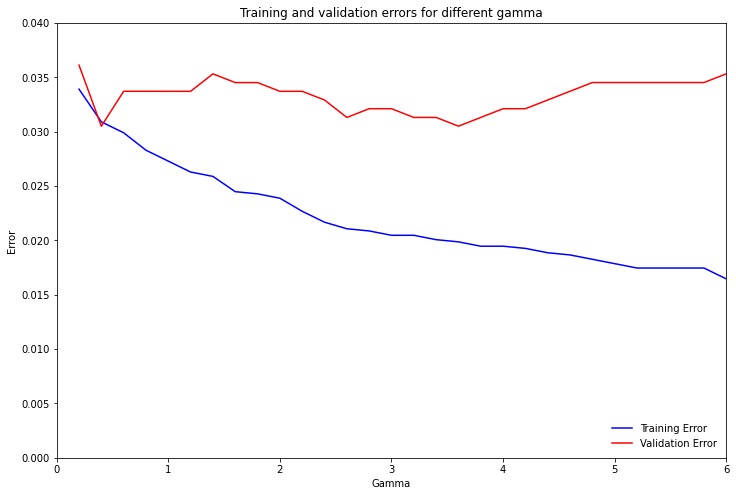

In [18]:
gamma_range = np.arange(0.2,6.2,0.2)
plt.figure(figsize=(12, 8))
plt.plot(gamma_range, train_err, c='b', label = 'Training Error')
plt.plot(gamma_range, valid_err, c='r', label = 'Validation Error')
plt.axis([0, 6,0.0,0.04])
plt.title('Training and validation errors for different gamma')
plt.xlabel('Gamma')
plt.ylabel('Error')
plt.legend(loc='lower right',frameon=False)
plt.show()
plt.close()

##### Best gamma for SVC is:

##### Calculate test error based on the model with best gamma

In [19]:
svm = SVC(C=1, gamma = best_g) #change gamma number here after
svm.fit(X_r,Y_r) #re-fit all training data with training dataset 
svm_true_error= 1 - svm.score(X_t, Y_t)
print ('SVM true error is: ', np.round(svm_true_error,6))

SVM true error is:  0.073777


# Optional task (best gamma and best penalty parameter in SVM)
##### We did optimisation using two different ways: A) using gridsearch, which is based on the best score AND B) using manually constructed grid and smallest validation error

### A)

In [34]:
from sklearn.svm import SVC

# Parameter space
gamma_range = list(np.arange(0.2,6.2,0.2)) # To optimize the gamma parameter of the SVM try values from 0.2 to 6 with a step of 0.2
c_range = list(np.arange(0.1, 10, 0.5)) # To optimize penalty parameter
gamma_range = [round(num, 1) for num in gamma_range]
c_range = [round(num, 1) for num in c_range]

# Making a parameter dictionary to use in built-in python library
param_grid = {'C': c_range,
              'gamma': gamma_range}

svm_grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
svm_grid.fit(x_t,y_t) #re-fit all training data with training dataset

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
[CV] C=0.1, gamma=0.2 ................................................
[CV] .................... C=0.1, gamma=0.2, score=0.955, total=   0.0s
[CV] C=0.1, gamma=0.2 ................................................
[CV] .................... C=0.1, gamma=0.2, score=0.955, total=   0.0s
[CV] C=0.1, gamma=0.2 ................................................
[CV] .................... C=0.1, gamma=0.2, score=0.945, total=   0.0s
[CV] C=0.1, gamma=0.2 ................................................
[CV] .................... C=0.1, gamma=0.2, score=0.970, total=   0.0s
[CV] C=0.1, gamma=0.2 ................................................
[CV] .................... C=0.1, gamma=0.2, score=0.950, total=   0.0s
[CV] C=0.1, gamma=0.4 ................................................
[CV] .................... C=0.1, gamma=0.4, score=0.955, total=   0.0s
[CV] C=0.1, gamma=0.4 ................................................
[CV] ........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Streaming output truncated to the last 5000 lines.
[CV] C=1.6, gamma=2.2 ................................................
[CV] .................... C=1.6, gamma=2.2, score=0.965, total=   0.0s
[CV] C=1.6, gamma=2.2 ................................................
[CV] .................... C=1.6, gamma=2.2, score=0.955, total=   0.0s
[CV] C=1.6, gamma=2.2 ................................................
[CV] .................... C=1.6, gamma=2.2, score=0.955, total=   0.0s
[CV] C=1.6, gamma=2.2 ................................................
[CV] .................... C=1.6, gamma=2.2, score=0.975, total=   0.0s
[CV] C=1.6, gamma=2.2 ................................................
[CV] .................... C=1.6, gamma=2.2, score=0.975, total=   0.0s
[CV] C=1.6, gamma=2.4 ................................................
[CV] .................... C=1.6, gamma=2.4, score=0.965, total=   0.0s
[CV] C=1.6, gamma=2.4 ................................................
[CV] .................... 

[Parallel(n_jobs=1)]: Done 3000 out of 3000 | elapsed:   55.4s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6,
                               5.1, 5.6, 6.1, 6.6, 7.1, 7.6, 8.1, 8.6, 9.1,
                               9.6],
                         'gamma': [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8,
                                   2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6,
                                   3.8, 4.0, 4.2, 4.4, 4.6, 4.8, 5.0, 5.2, 5.4,
                                   5.6, 5.8, 6.0]},
             pre_dispatch='2*n_job

##### Print best gamma and best C parameter based on gridsearch method and best score

In [35]:
print("Best gamma and C parameters using gridsearch are: " + str(svm_grid.best_params_))

Best gamma and C parameters using gridsearch are: {'C': 1.1, 'gamma': 4.2}


### B)

In [32]:
from sklearn.svm import SVC
import itertools

# Define gamma and C range paramter space
gamma_range = np.arange(0.2,6.2,0.2) # To optimize the gamma parameter of the SVM try values from 0.2 to 6 with a step of 0.2
c_range = np.arange(0.1, 10, 0.5)

# Make a grid with 
mesh = np.array(np.meshgrid(gamma_range, c_range)) #make a grid with both parameters
combinations = mesh.T.reshape(-1, 2) # this will result in all different combinations of parameters

# Export as two lists to use for iterations
g=list(combinations[:,0])
c=list(combinations[:,1])

train_err_b=[]
valid_err_b=[]
folds = 5
kf = StratifiedKFold(n_splits=folds)

for gamma, C in zip(g, c):

  tr_err = va_err = 0

  for tr_ix,va_ix in kf.split(Y_r,Y_r):

    x_t = X_r[tr_ix]
    y_t = Y_r[tr_ix]
    x_v = X_r[va_ix]
    y_v = Y_r[va_ix]

    svm = SVC(C=C, gamma = gamma) 
    svmfit = svm.fit(x_t,y_t) #re-fit all training data with training dataset


    svm_t_error = 1-svm.score(x_t,y_t) #calculate error with training set for that fold
    tr_err += svm_t_error
    svm_v_error = 1-svm.score(x_v,y_v) #calculate validation error for that fold with a validation dataset
    va_err += svm_v_error

  train_err_b.append(tr_err/folds)
  valid_err_b.append(va_err/folds)
  #print(str(np.round(gamma,2)),':', str(np.round(C,2)),':', tr_err/folds,va_err/folds)

##### Print best parameters (a combination of both)

In [36]:
best_g_b = g[np.argmin(valid_err_b)]
best_C_b = c[np.argmin(valid_err_b)]

print("smallest validation error is: "+ str(np.min(valid_err_b)))
print("best gamma is: "+ str(best_g_b))
print("best C is: "+ str(best_C_b))

smallest validation error is: 0.0296995983935743
best gamma is: 2.2
best C is: 0.1


##### Estimate true error based on optimized C and gamma values

In [41]:
svm_a = SVC(C=1.1, gamma = 4.2) #Best gamma and C parameters using gridsearch are: {'C': 1.1, 'gamma': 4.2}
svm_a.fit(X_r,Y_r) #re-fit all training data with training dataset 
svm_true_error_a= 1 - svm_a.score(X_t, Y_t)
print ('SVM true error (A approach) is: ', np.round(svm_true_error_a,6))

svm_b = SVC(C=0.1, gamma = 2.2) # gamma 2.2 and C 0.1
svm_b.fit(X_r,Y_r) #re-fit all training data with training dataset 
svm_true_error_b= 1 - svm_b.score(X_t, Y_t)
print ('SVM true error (B approach) is: ', np.round(svm_true_error_b,6))

SVM true error (A approach) is:  0.072173
SVM true error (B approach) is:  0.072975


# Comparison of classifiers

# For comparing the classifiers, we have used the approximate A) normal test and B) McNemar's test, both with a 95% confidence interval

##### Our classifiers

In [50]:
# Bayes models
naive_bayes = fit_NBayes(X_r, Y_r, X_t, bw=best_bw) # model 1
m1 = naive_bayes
gaussian_bayes =  NB_gaussian.predict(X_t) #model 2
m2=gaussian_bayes

# One parameter gamma optimization for SVM
svm_gamma_opt = SVC(C=1, gamma = best_g) 
svm_gamma_opt.fit(X_r,Y_r)
svm_gamma = svm_gamma_opt.predict(X_t) #model 3
m3=svm_gamma

# Two parameter optimization (gamma and C) for SVM using method A
svm_gamma_opt_a = SVC(C=1.1, gamma = 4.2) 
svm_gamma_opt_a.fit(X_r,Y_r)
svm_gamma_a = svm_gamma_opt_a.predict(X_t) #model 4
m4 = svm_gamma_a

# Two parameter optimization (gamma and C) for SVM using method B
svm_gamma_opt_b = SVC(C=0.1, gamma = 2.2) 
svm_gamma_opt_b.fit(X_r,Y_r)
svm_gamma_b = svm_gamma_opt_b.predict(X_t) #model 5
m5=svm_gamma_b

##### A) Approximate normal test

##### Just a quick look if data looks normal

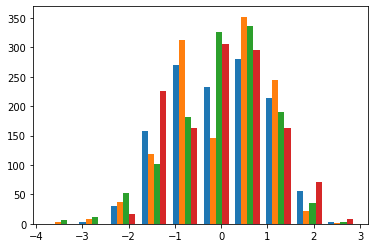

In [44]:
plt.hist(X_r) #check if training data looks approximately normal
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


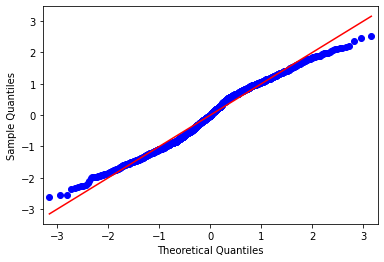

In [45]:
from statsmodels.graphics.gofplots import qqplot
qqplot(X_r[:,0], line='s')

plt.show()

In [51]:
import statistics as stats

def approx_normal(model):
    N = len(model)
    X=0
    for c in range(N):
        if model[c] != Y_t[c]:
            X+=1
            p=X/N
    stdev = np.sqrt(N*(X/N)*(1-(X/N)))
    return ("Mean is " + str(X) + " and confidence intervals are: " + str(1.96*stdev)) 

print("Naive Bayes: "+str(approx_normal(naive_bayes)))
print("Gaussian Bayes: "+str(approx_normal(gaussian_bayes)))
print("SVM with gamma optimisation: "+str(approx_normal(svm_gamma)))
print("SVM with gamma and C optimisation by method A: "+str(approx_normal(svm_gamma_a)))
print("SVM with gamma and C optimisation by method B: "+str(approx_normal(svm_gamma_b)))

Naive Bayes: Mean is 123 and confidence intervals are: 20.63756983884604
Gaussian Bayes: Mean is 186 and confidence intervals are: 24.656816817207723
SVM with gamma optimisation: Mean is 92 and confidence intervals are: 18.092881984593284
SVM with gamma and C optimisation by method A: Mean is 90 and confidence intervals are: 17.91062655813279
SVM with gamma and C optimisation by method B: Mean is 91 and confidence intervals are: 18.002070485926687


##### B) McNemar's test 

In [52]:
from mlxtend.evaluate import mcnemar_table

def mcnemars (model1, model2, classes):
  tb = mcnemar_table(y_target=classes, y_model1=model1, y_model2=model2)
  e01 = tb[0,1]
  e10 = tb[1,0]
  test = np.square(((abs(e01) - abs(e10))-1))/(e01 + e10)
  return("e01: " + str(e01) + " e10: " + str(e10) + " and test value: " + str(test))

In [48]:
print("Comparison between Naive Bayes with KDE and  Gaussian Bayes: " + str(mcnemars(m1, m2, Y_t)))
print("Comparison between Naive Bayes with KDE and  SVM (model3): " + str(mcnemars(m1, m3, Y_t)))
print("Comparison between Naive Bayes with KDE and  SVM (model4): : " + str(mcnemars(m1, m4, Y_t)))
print("Comparison between Naive Bayes with KDE and  SVM (model5): : " + str(mcnemars(m1, m5, Y_t)))
print("Comparison between SVM (model 3) and  SVM (model4): : " + str(mcnemars(m3, m4, Y_t)))
print("Comparison between SVM (model 3) and  SVM (model5): : " + str(mcnemars(m3, m5, Y_t)))
print("Comparison between SVM (model 4) and  SVM (model5): : " + str(mcnemars(m4, m5, Y_t)))

Comparison between Naive Bayes with KDE and  Gaussian Bayes: e01: 3 e10: 66 and test value: 59.36231884057971
Comparison between Naive Bayes with KDE and  SVM (model3): e01: 46 e10: 15 and test value: 14.754098360655737
Comparison between Naive Bayes with KDE and  SVM (model4): : e01: 50 e10: 17 and test value: 15.283582089552239
Comparison between Naive Bayes with KDE and  SVM (model5): : e01: 41 e10: 9 and test value: 19.22
Comparison between SVM (model 3) and  SVM (model4): : e01: 16 e10: 14 and test value: 0.03333333333333333
Comparison between SVM (model 3) and  SVM (model5): : e01: 12 e10: 11 and test value: 0.0
Comparison between SVM (model 4) and  SVM (model5): : e01: 11 e10: 12 and test value: 0.17391304347826086


##### If our test is more or equal to 3.84, we assume that models are different. Hence first 4 comparisons are significant with 95% confidence and last 3 comparisons are not significant.
